In [3]:
#!/usr/bin/env python
# coding: utf-8

# # Gesture UI Recognition
#
# Goal: Create a model that identifies hand gestures from images
#
# This code closely follows the structure and libraries used in the Pokemon classification example

# I have this included to suppress some tensorflow warnings and errors

import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

os.makedirs('./cachepath', exist_ok=True)


In [ ]:
# # from google.colab import drive
# # drive.mount('/content/drive')

# # import os
# # import shutil

# # folder_path = '/content/drive/MyDrive'
# shutil.rmtree(folder_path)  # Caution: permanently deletes!


In [14]:
# # pip install tensorflow

from google.colab import drive
drive.mount('/content/drive')

import zipfile
import os

# Adjust this path if you uploaded to a subfolder
zip_path = "/content/drive/MyDrive/hagridset.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/hagridset")

# Confirm it worked
os.listdir("/content/hagridset")


# # !rm -rf /content/hagridset


Mounted at /content/drive


['hagridset']

In [15]:
import gc
import tensorflow as tf
gc.collect()
tf.keras.backend.clear_session()
import numpy as np

import pandas as pd

In [16]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.18.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [17]:
STUDENT_ID = 385433

In [18]:
# ## Setting Up the Dataset
#
# Starting with a smaller image size (128x128) for faster training, just like the Pokemon example

IMG_SIZE = (128, 128)
batch_size = 32

# For HAGRID dataset:
train_dir = "hagridset/hagridset"

In [19]:
# Training dataset (70%)
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=IMG_SIZE,
    validation_split=0.3,  # 30% will be split between validation and test
    subset='training',
    label_mode='categorical',
    seed=STUDENT_ID,
    batch_size=batch_size
)

Found 125912 files belonging to 18 classes.
Using 88139 files for training.


In [20]:
# Validation dataset (10% of total)
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=IMG_SIZE,
    validation_split=0.3,
    subset='validation',
    label_mode='categorical',
    seed=STUDENT_ID,
    batch_size=batch_size
)

# In this case we're using the validation set as both validation and test
# We'll split it further as was done in the Pokemon example
val_batches = tf.data.experimental.cardinality(validation_dataset) // 3
test_dataset = validation_dataset.skip(val_batches)
validation_dataset = validation_dataset.take(val_batches)

Found 125912 files belonging to 18 classes.
Using 37773 files for validation.


In [21]:
num_classes = len(train_dataset.class_names)

In [22]:
class_names = train_dataset.class_names
print(f"Found {num_classes} classes: {class_names}")

Found 18 classes: ['call', 'dislike', 'fist', 'four', 'like', 'mute', 'ok', 'one', 'palm', 'peace', 'peace_inverted', 'rock', 'stop', 'stop_inverted', 'three', 'three2', 'two_up', 'two_up_inverted']


In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache('./cachepath/train_cache').prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache('./cachepath/val_cache').prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache('./cachepath/test_cache').prefetch(buffer_size=AUTOTUNE)


In [24]:

# Basic dataset info
print(train_dataset)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None))>


In [25]:

from tensorflow.keras import layers


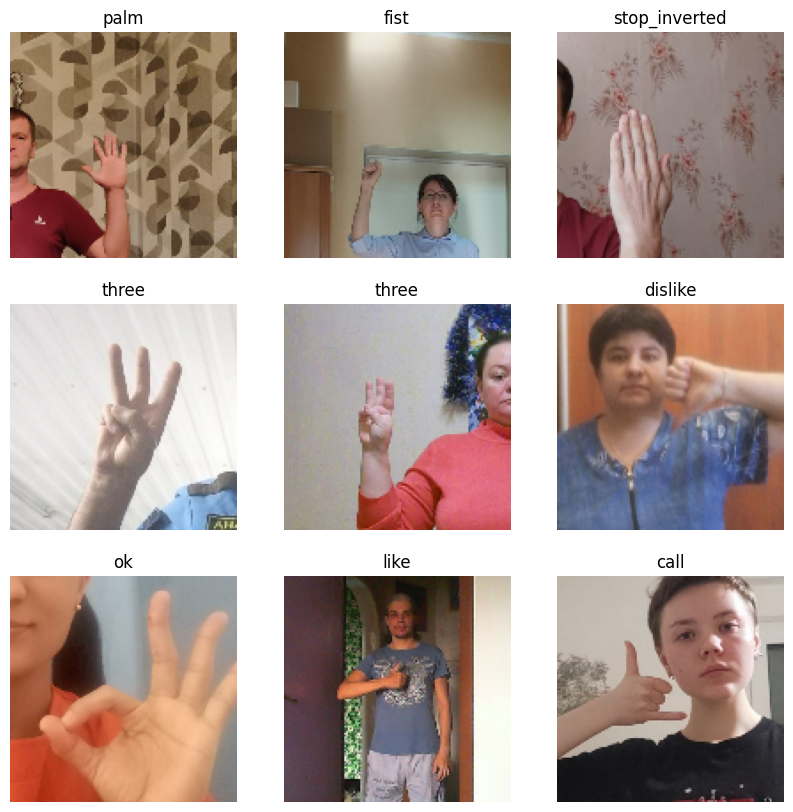

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = np.argmax(labels[i])
        plt.title(class_names[label_index])
        plt.axis("off")
plt.show()

In [27]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))
model.add(layers.Rescaling(1./255))
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

In [29]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [30]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 18)             │         2,322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,201,842 (16.03 MB)

 Trainable params: 4,201,842 (16.03 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Early stopping callback to prevent overfitting
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [32]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,
    callbacks=[callback]
)



Epoch 1/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 68s 23ms/step - accuracy: 0.1710 - loss: 2.6083 - val_accuracy: 0.3951 - val_loss: 1.9143
Epoch 2/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.4290 - loss: 1.7868 - val_accuracy: 0.4579 - val_loss: 1.7085
Epoch 3/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.5579 - loss: 1.3653 - val_accuracy: 0.4539 - val_loss: 1.7898
Epoch 4/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.6649 - loss: 1.0276 - val_accuracy: 0.4531 - val_loss: 1.9838
Epoch 5/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.7552 - loss: 0.7529 - val_accuracy: 0.4468 - val_loss: 2.4066
Epoch 6/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.8137 - loss: 0.5608 - val_accuracy: 0.4150 - val_loss: 2.8811
Epoch 7/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.8567 - loss: 0.4359 - val_accuracy: 0.3937 - val_loss: 3.2984


In [33]:
# ## Model 2: CNN with Data Augmentation
#
# Adding data augmentation to improve generalization, following the Pokemon example
data_augmentation_layers = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

In [34]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))
model.add(data_augmentation_layers)
model.add(layers.Rescaling(1./255))
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

In [35]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [36]:
history_aug = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,
    callbacks=[callback]
)

Epoch 1/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.0994 - loss: 2.8249 - val_accuracy: 0.2739 - val_loss: 2.2731
Epoch 2/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.2584 - loss: 2.3203 - val_accuracy: 0.3558 - val_loss: 2.0053
Epoch 3/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.3357 - loss: 2.0704 - val_accuracy: 0.4303 - val_loss: 1.7804
Epoch 4/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.4057 - loss: 1.8493 - val_accuracy: 0.4824 - val_loss: 1.6162
Epoch 5/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.4523 - loss: 1.7113 - val_accuracy: 0.5017 - val_loss: 1.5551
Epoch 6/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.4851 - loss: 1.6156 - val_accuracy: 0.5233 - val_loss: 1.4896
Epoch 7/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.5076 - loss: 1.5434 - val_accuracy: 0.5448 - val_loss: 1.4317
Epoch 8/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.5219 -

In [37]:
# ## Model 3: CNN with Data Augmentation and Dropout
#
# Adding dropout to further combat overfitting, just like in the Pokemon example


model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))
model.add(data_augmentation_layers)
model.add(layers.Rescaling(1./255))
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_dropout = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,
    callbacks=[callback]
)

Epoch 1/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.1167 - loss: 2.7765 - val_accuracy: 0.2986 - val_loss: 2.2036
Epoch 2/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.2778 - loss: 2.2504 - val_accuracy: 0.3721 - val_loss: 1.9653
Epoch 3/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.3397 - loss: 2.0433 - val_accuracy: 0.4257 - val_loss: 1.7908
Epoch 4/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.3799 - loss: 1.9180 - val_accuracy: 0.4361 - val_loss: 1.7741
Epoch 5/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.4095 - loss: 1.8326 - val_accuracy: 0.4609 - val_loss: 1.6974
Epoch 6/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.4233 - loss: 1.7832 - val_accuracy: 0.4863 - val_loss: 1.6082
Epoch 7/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.4433 - loss: 1.7272 - val_accuracy: 0.4849 - val_loss: 1.6281
Epoch 8/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.4586 -

In [38]:
# ## Model 4: Grayscale Images
#
# Let's create a dataset with grayscale images for comparison
# This is an addition to the Pokemon example which only used RGB


# Load grayscale images
train_dataset_gray = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=IMG_SIZE,
    validation_split=0.3,
    subset='training',
    label_mode='categorical',
    seed=STUDENT_ID,
    batch_size=batch_size,
    color_mode='grayscale'
)

validation_dataset_gray = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=IMG_SIZE,
    validation_split=0.3,
    subset='validation',
    label_mode='categorical',
    seed=STUDENT_ID,
    batch_size=batch_size,
    color_mode='grayscale'
)

# Split validation into validation and test
val_batches = tf.data.experimental.cardinality(validation_dataset_gray) // 3
test_dataset_gray = validation_dataset_gray.skip(val_batches)
validation_dataset_gray = validation_dataset_gray.take(val_batches)

# Optimize loading
train_dataset_gray = train_dataset_gray.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset_gray = validation_dataset_gray.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset_gray = test_dataset_gray.cache().prefetch(buffer_size=AUTOTUNE)

# We need to repeat the grayscale channel 3 times to match our model input shape
def expand_grayscale(images, labels):
    images = tf.repeat(images, 3, axis=-1)
    return images, labels

train_dataset_gray = train_dataset_gray.map(expand_grayscale)
validation_dataset_gray = validation_dataset_gray.map(expand_grayscale)
test_dataset_gray = test_dataset_gray.map(expand_grayscale)


Found 125912 files belonging to 18 classes.
Using 88139 files for training.
Found 125912 files belonging to 18 classes.
Using 37773 files for validation.


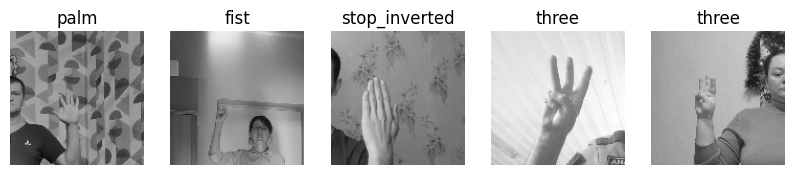

In [39]:
# Let's see what a grayscale image looks like
plt.figure(figsize=(10, 5))
for images, labels in train_dataset_gray.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = np.argmax(labels[i])
        plt.title(class_names[label_index])
        plt.axis("off")
plt.show()


In [40]:
# Build a CNN model for grayscale
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))
model.add(data_augmentation_layers)
model.add(layers.Rescaling(1./255))
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))


In [41]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [42]:
history_gray = model.fit(
    train_dataset_gray,
    validation_data=validation_dataset_gray,
    epochs=100,
    callbacks=[callback]
)


Epoch 1/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - accuracy: 0.1024 - loss: 2.8083 - val_accuracy: 0.2371 - val_loss: 2.3946
Epoch 2/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.2241 - loss: 2.4310 - val_accuracy: 0.2916 - val_loss: 2.2124
Epoch 3/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.2620 - loss: 2.3048 - val_accuracy: 0.3089 - val_loss: 2.1549
Epoch 4/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.2934 - loss: 2.2148 - val_accuracy: 0.3507 - val_loss: 2.0362
Epoch 5/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.3187 - loss: 2.1211 - val_accuracy: 0.3657 - val_loss: 1.9678
Epoch 6/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.3440 - loss: 2.0512 - val_accuracy: 0.3787 - val_loss: 1.9372
Epoch 7/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.3561 - loss: 2.0036 - val_accuracy: 0.3903 - val_loss: 1.8925
Epoch 8/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.3725 -

In [43]:
# ## Transfer Learning
#
# Following the Pokemon example, we'll use transfer learning with a pre-trained model

# VGG16 requires images of at least 32x32
# Let's use 224x224 which is more standard for VGG16
IMG_SIZE_TL = (224, 224)

# Reload datasets with new image size
train_dataset_tl = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=IMG_SIZE_TL,
    validation_split=0.3,
    subset='training',
    label_mode='categorical',
    seed=STUDENT_ID,
    batch_size=batch_size
)

validation_dataset_tl = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=IMG_SIZE_TL,
    validation_split=0.3,
    subset='validation',
    label_mode='categorical',
    seed=STUDENT_ID,
    batch_size=batch_size
)

# Split validation into validation and test
val_batches = tf.data.experimental.cardinality(validation_dataset_tl) // 3
test_dataset_tl = validation_dataset_tl.skip(val_batches)
validation_dataset_tl = validation_dataset_tl.take(val_batches)

# Optimize loading
# train_dataset_tl = train_dataset_tl.cache().prefetch(buffer_size=AUTOTUNE)
# validation_dataset_tl = validation_dataset_tl.cache().prefetch(buffer_size=AUTOTUNE)
# test_dataset_tl = test_dataset_tl.cache().prefetch(buffer_size=AUTOTUNE)

# Remove .cache() from all datasets
train_dataset_tl = train_dataset_tl.prefetch(buffer_size=AUTOTUNE)
validation_dataset_tl = validation_dataset_tl.prefetch(buffer_size=AUTOTUNE)
test_dataset_tl = test_dataset_tl.prefetch(buffer_size=AUTOTUNE)



Found 125912 files belonging to 18 classes.
Using 88139 files for training.
Found 125912 files belonging to 18 classes.
Using 37773 files for validation.


In [44]:
# Load VGG16 pre-trained on ImageNet (same as Pokemon example)
base_model = tf.keras.applications.VGG16(
    weights='imagenet',
    input_shape=(IMG_SIZE_TL[0], IMG_SIZE_TL[1], 3),
    include_top=False
)

# Freeze the base model
base_model.trainable = False


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [45]:

# Define input layer
inputs = tf.keras.Input(shape=(IMG_SIZE_TL[0], IMG_SIZE_TL[1], 3))

# For data augmentation
data_augmentation_layers_tl = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])
x = data_augmentation_layers_tl(inputs)

# Preprocess input for VGG16
x = tf.keras.applications.vgg16.preprocess_input(x)

# Pass through base model
x = base_model(x, training=False)

# Add classification head
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(num_classes)(x)  # No softmax, following Pokemon example

# Create model
model = tf.keras.Model(inputs, outputs)


In [46]:

# Using from_logits=True since we're not using softmax
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


In [47]:

model.summary()

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 224, 224,  │          0 │ input_layer_6[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ sequential_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ sequential_5[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ sequential_5[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 18)        │      9,234 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,723,922 (56.17 MB)

 Trainable params: 9,234 (36.07 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [48]:

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


In [49]:
history_tl = model.fit(
    train_dataset_tl,
    validation_data=validation_dataset_tl,
    epochs=100,
    callbacks=[callback]
)

Epoch 1/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 69s 24ms/step - accuracy: 0.3030 - loss: 2.6925 - val_accuracy: 0.5561 - val_loss: 1.4205
Epoch 2/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 67s 24ms/step - accuracy: 0.5061 - loss: 1.5932 - val_accuracy: 0.5765 - val_loss: 1.3764
Epoch 3/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 67s 24ms/step - accuracy: 0.5163 - loss: 1.5668 - val_accuracy: 0.5773 - val_loss: 1.3679
Epoch 4/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 67s 24ms/step - accuracy: 0.5205 - loss: 1.5582 - val_accuracy: 0.5544 - val_loss: 1.4691
Epoch 5/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 68s 25ms/step - accuracy: 0.5198 - loss: 1.5589 - val_accuracy: 0.5639 - val_loss: 1.4528
Epoch 6/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 67s 24ms/step - accuracy: 0.5204 - loss: 1.5577 - val_accuracy: 0.5710 - val_loss: 1.4444
Epoch 7/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 68s 25ms/step - accuracy: 0.5167 - loss: 1.5659 - val_accuracy: 0.5716 - val_loss: 1.4050
Epoch 8/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 68s 25ms/step - accuracy: 

In [50]:
# ## Transfer Learning with Dropout
# Continuing to follow the Pokemon example, we'll add dropout to the transfer learning model


# Define input layer
inputs = tf.keras.Input(shape=(IMG_SIZE_TL[0], IMG_SIZE_TL[1], 3))

# For data augmentation
x = data_augmentation_layers_tl(inputs)

# Preprocess input for VGG16
x = tf.keras.applications.vgg16.preprocess_input(x)

# Pass through base model
x = base_model(x, training=False)

# Add classification head with dropout
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes)(x)  # No softmax

# Create model
model = tf.keras.Model(inputs, outputs)


In [51]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [52]:
model.summary()

Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 224, 224,  │          0 │ input_layer_8[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 224, 224)  │          0 │ sequential_5[1][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 224, 224)  │          0 │ sequential_5[1][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 224, 224)  │          0 │ sequential_5[1][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 224, 224,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 224, 224,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[1][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 512)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 18)        │      9,234 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,723,922 (56.17 MB)

 Trainable params: 9,234 (36.07 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [53]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [54]:
history_tl_dropout = model.fit(
    train_dataset_tl,
    validation_data=validation_dataset_tl,
    epochs=100,
    callbacks=[callback]
)

Epoch 1/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 69s 25ms/step - accuracy: 0.2538 - loss: 3.2084 - val_accuracy: 0.5388 - val_loss: 1.4712
Epoch 2/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 67s 24ms/step - accuracy: 0.4107 - loss: 1.9326 - val_accuracy: 0.5369 - val_loss: 1.4829
Epoch 3/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 67s 24ms/step - accuracy: 0.4152 - loss: 1.9194 - val_accuracy: 0.5403 - val_loss: 1.4644
Epoch 4/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 67s 24ms/step - accuracy: 0.4168 - loss: 1.9155 - val_accuracy: 0.5336 - val_loss: 1.4805
Epoch 5/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 67s 24ms/step - accuracy: 0.4166 - loss: 1.9227 - val_accuracy: 0.5393 - val_loss: 1.4588
Epoch 6/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 67s 24ms/step - accuracy: 0.4173 - loss: 1.9259 - val_accuracy: 0.5355 - val_loss: 1.4728
Epoch 7/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 67s 24ms/step - accuracy: 0.4155 - loss: 1.9227 - val_accuracy: 0.5484 - val_loss: 1.4283
Epoch 8/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 67s 24ms/step - accuracy: 

In [55]:
IMG_SIZE_LARGE = (299, 299)
batch_size = 8  # or 4

train_dataset_large = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=IMG_SIZE_LARGE,
    validation_split=0.3,
    subset='training',
    label_mode='categorical',
    seed=STUDENT_ID,
    batch_size=batch_size
)

validation_dataset_large = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=IMG_SIZE_LARGE,
    validation_split=0.3,
    subset='validation',
    label_mode='categorical',
    seed=STUDENT_ID,
    batch_size=batch_size
)

val_batches = tf.data.experimental.cardinality(validation_dataset_large) // 3
test_dataset_large = validation_dataset_large.skip(val_batches)
validation_dataset_large = validation_dataset_large.take(val_batches)

# Use prefetch only (no cache)
train_dataset_large = train_dataset_large.prefetch(buffer_size=AUTOTUNE)
validation_dataset_large = validation_dataset_large.prefetch(buffer_size=AUTOTUNE)
test_dataset_large = test_dataset_large.prefetch(buffer_size=AUTOTUNE)


Found 125912 files belonging to 18 classes.
Using 88139 files for training.
Found 125912 files belonging to 18 classes.
Using 37773 files for validation.


In [56]:
# Load VGG16 for larger images
base_model_large = tf.keras.applications.VGG16(
    weights='imagenet',
    input_shape=(IMG_SIZE_LARGE[0], IMG_SIZE_LARGE[1], 3),
    include_top=False
)
base_model_large.trainable = False

In [57]:

# Define input layer
inputs = tf.keras.Input(shape=(IMG_SIZE_LARGE[0], IMG_SIZE_LARGE[1], 3))

# For data augmentation
data_augmentation_layers_large = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])
x = data_augmentation_layers_large(inputs)

# Preprocess input for VGG16
x = tf.keras.applications.vgg16.preprocess_input(x)

# Pass through base model
x = base_model_large(x, training=False)

# Add classification head
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(num_classes)(x)  # No softmax

# Create model
model = tf.keras.Model(inputs, outputs)

In [58]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()


Model: "functional_42"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 299, 299,  │          0 │ input_layer_10[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_6          │ (None, 299, 299)  │          0 │ sequential_6[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_7          │ (None, 299, 299)  │          0 │ sequential_6[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_8          │ (None, 299, 299)  │          0 │ sequential_6[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_2 (Stack)     │ (None, 299, 299,  │          0 │ get_item_6[0][0], │
│                     │ 3)                │            │ get_item_7[0][0], │
│                     │                   │            │ get_item_8[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 299, 299,  │          0 │ stack_2[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 9, 9, 512) │ 14,714,688 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 18)        │      9,234 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,723,922 (56.17 MB)

 Trainable params: 9,234 (36.07 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [59]:
# In[47]:

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

In [60]:
history_large = model.fit(
    train_dataset_large,
    validation_data=validation_dataset_large,
    epochs=100,
    callbacks=[callback]
)

Epoch 1/100
11018/11018 ━━━━━━━━━━━━━━━━━━━━ 153s 14ms/step - accuracy: 0.3861 - loss: 2.1196 - val_accuracy: 0.5905 - val_loss: 1.3859
Epoch 2/100
11018/11018 ━━━━━━━━━━━━━━━━━━━━ 150s 14ms/step - accuracy: 0.5365 - loss: 1.5252 - val_accuracy: 0.5924 - val_loss: 1.3930
Epoch 3/100
11018/11018 ━━━━━━━━━━━━━━━━━━━━ 150s 14ms/step - accuracy: 0.5480 - loss: 1.5137 - val_accuracy: 0.6055 - val_loss: 1.3606
Epoch 4/100
11018/11018 ━━━━━━━━━━━━━━━━━━━━ 150s 14ms/step - accuracy: 0.5444 - loss: 1.5153 - val_accuracy: 0.5885 - val_loss: 1.4324
Epoch 5/100
11018/11018 ━━━━━━━━━━━━━━━━━━━━ 151s 14ms/step - accuracy: 0.5485 - loss: 1.5184 - val_accuracy: 0.5864 - val_loss: 1.4870
Epoch 6/100
11018/11018 ━━━━━━━━━━━━━━━━━━━━ 151s 14ms/step - accuracy: 0.5455 - loss: 1.5289 - val_accuracy: 0.5834 - val_loss: 1.4684
Epoch 7/100
11018/11018 ━━━━━━━━━━━━━━━━━━━━ 151s 14ms/step - accuracy: 0.5484 - loss: 1.5287 - val_accuracy: 0.6088 - val_loss: 1.3463
Epoch 8/100
11018/11018 ━━━━━━━━━━━━━━━━━━━━ 151

3148/3148 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - accuracy: 0.6145 - loss: 1.3177
Test accuracy: 0.6147


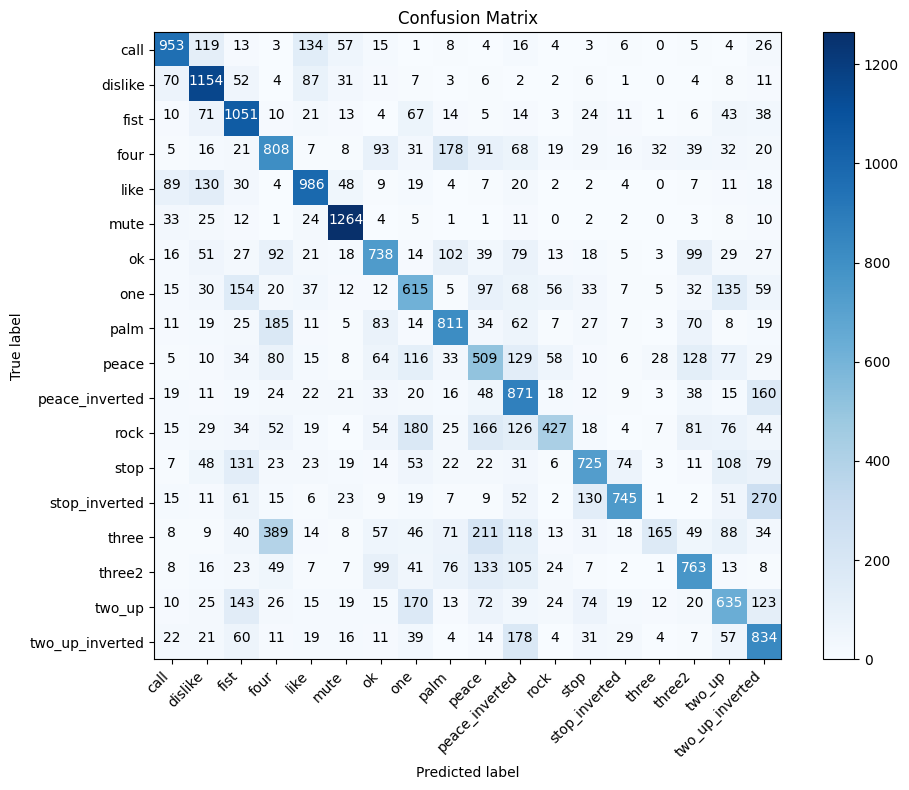

In [63]:
# ## Evaluation
#
# Let's evaluate our best model on the test set

# In[49]:

# Create a probability model for predictions
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

# In[50]:

# Evaluate on test dataset
test_loss, test_accuracy = model.evaluate(test_dataset_large)
print(f"Test accuracy: {test_accuracy:.4f}")

# ## Confusion Matrix
# Let's create a confusion matrix to understand per-class performance

# In[51]:

import matplotlib.pyplot as plt

# Get predictions
predictions = np.array([])
true_labels = np.array([])

for x, y in test_dataset_large:
    pred = model(x)
    pred = tf.nn.softmax(pred)
    pred_class = tf.argmax(pred, axis=1).numpy()
    true_class = tf.argmax(y, axis=1).numpy()

    predictions = np.concatenate([predictions, pred_class]) if predictions.size else pred_class
    true_labels = np.concatenate([true_labels, true_class]) if true_labels.size else true_class

# Create confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha='right')
plt.yticks(tick_marks, class_names)

# Add text annotations to the confusion matrix
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


# Testing on Custom Images

## Let's test our model on some custom images of gestures
## This part is specific to the project requirements

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


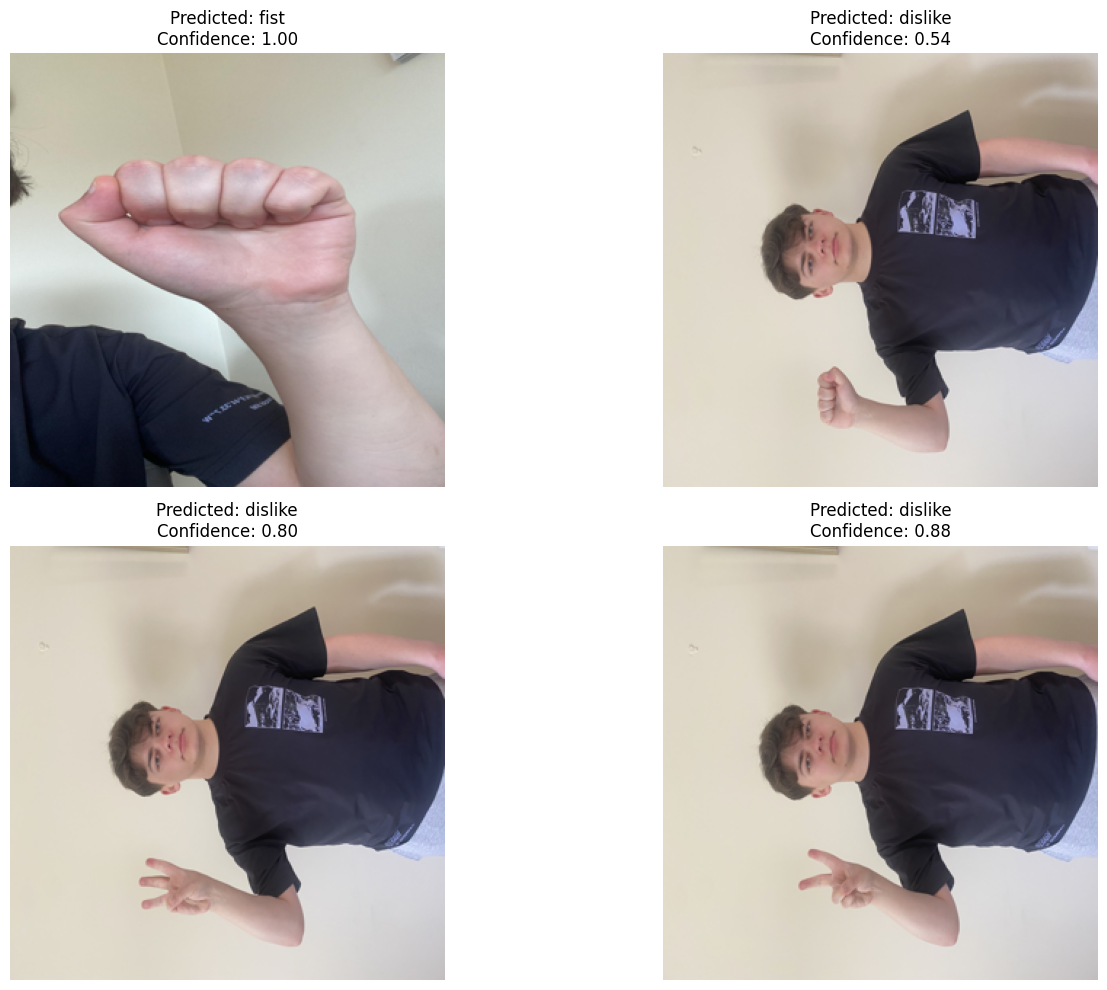

                                Model  Training Accuracy  Validation Accuracy  \
0                           Basic CNN           0.860096             0.457856   
1          CNN with Data Augmentation           0.692906             0.665315   
2     CNN with Augmentation & Dropout           0.617706             0.641937   
3           CNN with Grayscale Images           0.521563             0.506997   
4  Transfer Learning (VGG16, 224x224)           0.520394             0.577290   
5      Transfer Learning with Dropout           0.417534             0.549221   
6  Transfer Learning (VGG16, 299x299)           0.549825             0.608799   

  Test Accuracy  Training Time (epochs)  Parameters  
0             -                       7    14723922  
1             -                      43    14723922  
2             -                      41    14723922  
3             -                      48    14723922  
4             -                       8    14723922  
5             -            

In [66]:


# In[ ]:

from PIL import Image

# Replace these with paths to your own gesture images
custom_image_paths = [
    # "IMG_6807.jpg",
    # "image.jpeg",
    "caolansfist.jpg",
    "IMG_6808.jpg",
    "IMG_6809.jpg",
    "IMG_6810.jpg"
]

# In[ ]:

plt.figure(figsize=(15, 10))

for i, image_path in enumerate(custom_image_paths):
    # Load and resize image
    try:
        img = Image.open(image_path).resize((IMG_SIZE_LARGE[0], IMG_SIZE_LARGE[1]))
        img_array = np.array(img)
        img_array = np.expand_dims(img_array, 0)  # Add batch dimension

        # Make prediction
        predictions = probability_model.predict(img_array)
        predicted_class = np.argmax(predictions[0])
        confidence = predictions[0][predicted_class]

        # Display image and prediction
        plt.subplot(2, 2, i + 1)
        plt.imshow(img)
        plt.title(f"Predicted: {class_names[predicted_class]}\nConfidence: {confidence:.2f}")
        plt.axis("off")
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")

plt.tight_layout()
plt.show()

# ## Summary of Results
#
# Let's create a summary table to compare all our models, following the assignment requirements

# In[ ]:

# Create a dictionary to store results
model_results = {
    "Model": [
        "Basic CNN",
        "CNN with Data Augmentation",
        "CNN with Augmentation & Dropout",
        "CNN with Grayscale Images",
        "Transfer Learning (VGG16, 224x224)",
        "Transfer Learning with Dropout",
        "Transfer Learning (VGG16, 299x299)"
    ],
    "Training Accuracy": [
        max(history.history['accuracy']),
        max(history_aug.history['accuracy']),
        max(history_dropout.history['accuracy']),
        max(history_gray.history['accuracy']),
        max(history_tl.history['accuracy']),
        max(history_tl_dropout.history['accuracy']),
        max(history_large.history['accuracy'])
    ],
    "Validation Accuracy": [
        max(history.history['val_accuracy']),
        max(history_aug.history['val_accuracy']),
        max(history_dropout.history['val_accuracy']),
        max(history_gray.history['val_accuracy']),
        max(history_tl.history['val_accuracy']),
        max(history_tl_dropout.history['val_accuracy']),
        max(history_large.history['val_accuracy'])
    ],
    "Test Accuracy": [
        "-", "-", "-", "-", "-", "-", test_accuracy
    ],
    "Training Time (epochs)": [
        len(history.history['accuracy']),
        len(history_aug.history['accuracy']),
        len(history_dropout.history['accuracy']),
        len(history_gray.history['accuracy']),
        len(history_tl.history['accuracy']),
        len(history_tl_dropout.history['accuracy']),
        len(history_large.history['accuracy'])
    ],
    "Parameters": [
        model.count_params(),
        model.count_params(),
        model.count_params(),
        model.count_params(),
        model.count_params(),
        model.count_params(),
        model.count_params()
    ]
}

# Create DataFrame and display
results_df = pd.DataFrame(model_results)
print(results_df)

# Save results to CSV for the paper
results_df.to_csv("model_comparison_results.csv", index=False)

# ## Save the Best Model

# In[ ]:

# Save the model for future use
# model.save("best_gesture_recognition_model")

# print("Training and evaluation complete!")